In [244]:
import os
import pandas as pd
import matplotlib.pyplot as plt

**DATA PREPROCESSING**

In [245]:
with open('dataset/data.csv', 'r') as f:
    print(f.readline().replace('\n','').split(','))

['Country name', 'Ladder score', 'Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual']


In [246]:
# Create 2-D array "data"
data = []
with open('dataset/data.csv', 'r') as f:
    line = f.readline()
    line = line.replace('\n', '').split(',')
    data.append(line)
    for line in f.readlines():
        line = line.replace('\n', '').split(',')
        line_int = [line[0]]
        for i in range(1,len(line)):
            if line[i] == '':
                line_int.append(0.0)
                continue
            line_int.append(float(line[i]))
        data.append(line_int)


In [247]:
# Create "dataframe"
dataframe = pd.DataFrame(data[1:], columns = data[0])

**NAIVE**

/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_3915/3160331487.py:16: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])
/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_3915/3160331487.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_xticklabels(top_ten_happiness['Country name'], rotation=90)
/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_3915/3160331487.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(top_ten_gdp['Country name'], rotation=90)


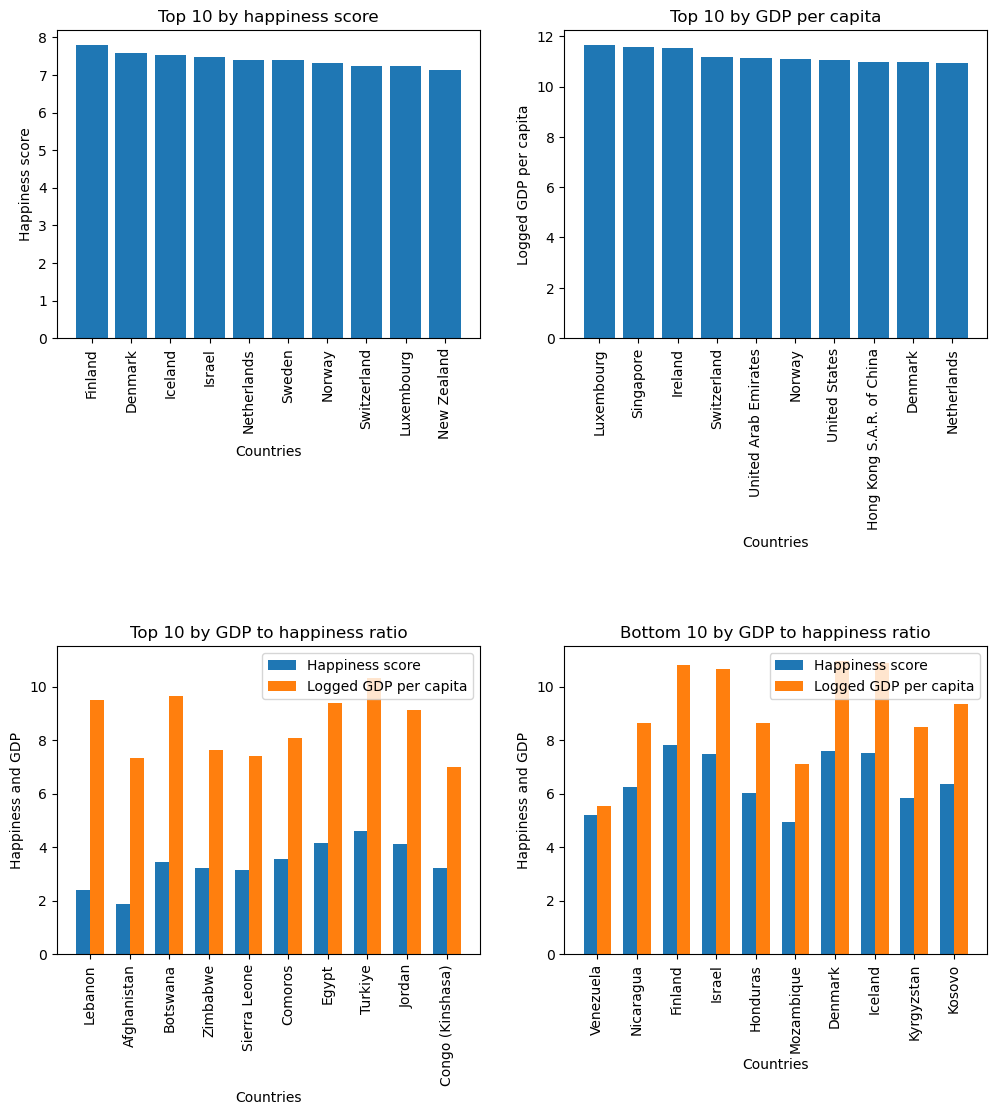

In [248]:
# 4 top 10 plots
top_ten_happiness = dataframe.head(10)

sorted_df_gdp = dataframe.sort_values(by='Logged GDP per capita', ascending=False)
top_ten_gdp = sorted_df_gdp.head(10)

dataframe['GDP to happiness ratio'] = dataframe['Logged GDP per capita']/dataframe['Ladder score']
sorted_df_ratio = dataframe.sort_values(by='GDP to happiness ratio', ascending=False)
top_ten_ratio = sorted_df_ratio.head(10)
sorted_df_ratio_reverse = dataframe.sort_values(by='GDP to happiness ratio', ascending=True)
last_ten_ratio = sorted_df_ratio_reverse.head(10)


fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])

axs[0,0].bar(top_ten_happiness['Country name'], top_ten_happiness['Ladder score'])
axs[0,0].set_xlabel('Countries')
axs[0,0].set_ylabel('Happiness score')
axs[0,0].set_title('Top 10 by happiness score')
axs[0,0].set_xticklabels(top_ten_happiness['Country name'], rotation=90)

axs[0,1].bar(top_ten_gdp['Country name'], top_ten_gdp['Logged GDP per capita'])
axs[0,1].set_xlabel('Countries')
axs[0,1].set_ylabel('Logged GDP per capita')
axs[0,1].set_title('Top 10 by GDP per capita')
axs[0,1].set_xticklabels(top_ten_gdp['Country name'], rotation=90)

index = [i for i in range(0,10)]
axs[1,0].bar(index, top_ten_ratio['Ladder score'], 0.35, label = "Happiness score")
axs[1,0].bar([i+0.35 for i in index], top_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,0].set_xlabel('Countries')
axs[1,0].set_ylabel('Happiness and GDP')
axs[1,0].set_title('Top 10 by GDP to happiness ratio')
axs[1,0].set_xticks([i+(0.35/2) for i in index])
axs[1,0].set_xticklabels(top_ten_ratio['Country name'], rotation=90)
axs[1,0].legend()

axs[1,1].bar(index, last_ten_ratio['Ladder score'], 0.35, label = "Happiness score")
axs[1,1].bar([i+0.35 for i in index], last_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,1].set_xlabel('Countries')
axs[1,1].set_ylabel('Happiness and GDP')
axs[1,1].set_title('Bottom 10 by GDP to happiness ratio')
axs[1,1].set_xticks([i+(0.35/2) for i in index])
axs[1,1].set_xticklabels(last_ten_ratio['Country name'], rotation=90)
axs[1,1].legend()

plt.subplots_adjust(hspace=1)

plt.show()

**DEEP LEARNING PREDICTION USING GDP**

In [249]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import save_model
from keras.models import load_model
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, Range1d

In [250]:
# Label regions of countries for future use
region_data = []
with open('dataset/country_region.csv', 'r') as f:
    line = f.readline()
    line = line.replace('\n', '').split(',')
    region_data.append(line)
    for line in f.readlines():
        line = line.replace('\n', '').split(',')
        region_data.append(line)
        if len(line)==12:
            print(line[0])

region_dataframe = pd.DataFrame(region_data[1:], columns = region_data[0])

# Get a dictionary matching each country to their corresponding region
country_region = {}
countries, regions = region_dataframe['name'].tolist(), region_dataframe['sub-region'].tolist()
for i in range(len(countries)):
    country_region[countries[i]] = regions[i]

# Get the full list of regions
regions = list(set(regions))
regions.sort()

# Add columns to dataframe
for region in regions:
    dataframe[region] = 0

# Label the region of each country
for index, row in dataframe.iterrows():
    region = country_region[row['Country name']]
    dataframe.at[index, region] = 1

In [251]:
shuffled_dataframe = dataframe.sample(frac=1).reset_index(drop=True)

In [252]:
model = Sequential()

model.add(Dense(64, input_shape=(1,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.fit(shuffled_dataframe['Logged GDP per capita'][:100], shuffled_dataframe['Ladder score'][:100], epochs=100)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(shuffled_dataframe['Logged GDP per capita'][100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP.h5')

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 33.0222
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 23.7516
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 16.5364
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 11.1186
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 6.9595
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 4.0759
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 2.1458
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 1.0477
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 0.6055
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 0.5114
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 0.5460
Epoch 12/100
4/4 [==============================] - 0s 1ms/step - loss: 0.6289
Epoch 13/100
4/4 [==============================] - 0s 1m

In [253]:
# Get predictions
def get_visualization_source(model):
    model = load_model(model)
    y_pred = model.predict(shuffled_dataframe['Logged GDP per capita'][100:137])
    y_pred = [item[0] for item in y_pred]
    y_actual = shuffled_dataframe['Ladder score'][100:137].tolist()
    labels = shuffled_dataframe['Country name'][100:137].tolist()
    return y_pred, y_actual, labels

In [254]:
# VISUALIZE with model_GDP

y_pred, y_actual, labels = get_visualization_source('model_GDP.h5')

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

2/2 [==============================] - 0s 2ms/step


**DEEP LEARNING USING GDP AND REGION**

In [255]:
print(dataframe.columns)

Index(['Country name', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'GDP to happiness ratio', '""',
       'Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe'],
      dtype='obj

In [256]:
features = ['Logged GDP per capita', 'Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe']
x = dataframe[features].values


print(x)

[[10.792  0.     0.    ...  0.     0.     0.   ]
 [10.962  0.     0.    ...  0.     0.     0.   ]
 [10.896  0.     0.    ...  0.     0.     0.   ]
 ...
 [ 7.394  0.     0.    ...  1.     0.     0.   ]
 [ 9.478  0.     0.    ...  0.     1.     0.   ]
 [ 7.324  0.     0.    ...  0.     0.     0.   ]]


In [257]:
model = Sequential()

model.add(Dense(64, input_shape=(18,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.fit(x[:100], shuffled_dataframe['Ladder score'][:100], epochs=100)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(x[100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP_region.h5')


Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 8.8758
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 2.7224
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 1.7320
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 2.2341
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 2.1070
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 1.6874
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 1.4569
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 1.4946
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 1.4877
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 1.4290
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3921
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3756
Epoch 13/100
4/4 [==============================] - 0s 1ms/st

In [258]:
model = load_model('model_GDP_region.h5')
y_pred = model.predict(x[100:])
y_pred = [item[0] for item in y_pred]
y_actual = shuffled_dataframe['Ladder score'][100:].tolist()
labels = shuffled_dataframe['Country name'][100:].tolist()

5/5 [==============================] - 0s 1ms/step


In [259]:
# VISUALIZE with model_GDP_region

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita,region).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita,region)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

In [264]:
features = ['Logged GDP per capita', 'Healthy life expectancy']
x = dataframe[features].values
x[1] = x[1]**2

In [265]:
model = Sequential()

model.add(Dense(64, input_shape=(2,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.fit(x[:100], shuffled_dataframe['Ladder score'][:100], epochs=100)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(x[100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP_health.h5')

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 554.0606
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 176.0962
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 246.9798
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 57.9337
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 68.3182
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 67.3821
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 24.7473
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 50.4063
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 26.2821
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 24.4884
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 24.0631
Epoch 12/100
4/4 [==============================] - 0s 2ms/step - loss: 21.2619
Epoch 13/100
4/4 [============================

In [266]:
model = load_model('model_GDP_health.h5')
y_pred = model.predict(x)
y_pred = [item[0] for item in y_pred]
y_actual = shuffled_dataframe['Ladder score'].tolist()
labels = shuffled_dataframe['Country name'].tolist()

5/5 [==============================] - 0s 1ms/step


In [267]:
# VISUALIZE with model_GDP_health

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita,health).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita,health)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)